Iterasjon  0  L =  1.232094623027962 
Iterasjon  1  L =  1.0841293387709232 
Iterasjon  2  L =  0.96269928873332 
Iterasjon  3  L =  0.9140134158014485 
Iterasjon  4  L =  0.8934463873019949 
Iterasjon  5  L =  0.909531972102742 
Iterasjon  6  L =  0.9400070138243686 
Iterasjon  7  L =  0.9670331074777018 
Iterasjon  8  L =  1.0417438731753084 
Iterasjon  9  L =  1.019910998890446 
Iterasjon  10  L =  1.311188536017791 
Iterasjon  11  L =  1.3592764327295654 
Iterasjon  12  L =  1.2785996335232768 
Iterasjon  13  L =  1.1797933844458453 
Iterasjon  14  L =  1.0724431352079036 
Iterasjon  15  L =  1.0791054561862423 
Iterasjon  16  L =  1.0409550691420322 
Iterasjon  17  L =  1.1457083803627452 
Iterasjon  18  L =  1.122161427456399 
Iterasjon  19  L =  1.1918650907944808 
Iterasjon  20  L =  1.2512333068852755 
Iterasjon  21  L =  1.2492803038488662 
Iterasjon  22  L =  1.2646126588511104 
Iterasjon  23  L =  1.225998020690125 
Iterasjon  24  L =  1.1893908529178405 
Iterasjon  25  L =

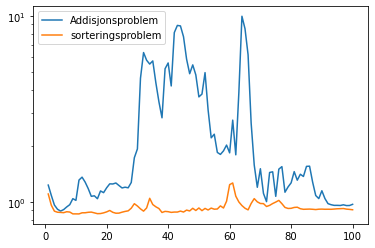

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from training_algorithm import TrainingAlgorithm

nn_adding_0, mean_losses_adding_0 = TrainingAlgorithm(1) #addisjonsproblem

nn_adding_1, mean_losses_adding_1 = TrainingAlgorithm(0) #sorteringsproblem

n = np.arange(1, len(mean_losses_adding_1)+1)
plt.yscale("log")
plt.plot(n, mean_losses_adding_0, label='Addisjonsproblem')
plt.plot(n, mean_losses_adding_1, label='sorteringsproblem')
plt.legend()
plt.show()

Under trening av algoritmen opplevede vi lenge to større feil ved minimering av Loss-funksjonen. Gjennom debuggingen fant vi deler av problemet da vi i bacwards for CrossEntropy hadde implementert feil formel for utregningen av dLdY. Dette løste imidlertidig ikke alt, og Loss-funksjonen synker ikke slik vi ønsker. Vi har derfor likevel valgt å vise til debugging-prosessen vi gjennomgikk for følgende feil hvor feil 2 er løst:\
**Feil 1:** Både step_Adam og step_gd gir en økning i verdien til Loss-funksjonen. Step_Adam varierer før den divergerer, til forskjell fra step_gd som er helt lineær og svakt økende.\
**Feil 2:** Bruk av step_Adam gir "RuntimeWarning: divide by zero encountered in log q = -np.log(p)" for attention forward. 

Under debuggingen  har vi utforsket følgende hypoteser: 
1) Matriseelementer i p i attention forward er lik null, og np.log(p) gir feilmenldinger da logaritmen til 0 ikke eksisterer. Det er flere grunner til at p kan bli lik null, blant dem:
    - self.Y = onehot(y,m) blir null: dersom onehot ikke fungerer som den skal og og ikke leverer verdier lik 1 vil den kunne gi en null-matrise for self.Y = onehot(y,m). Vi sjekket derfor max-verdien i hver kolonne til onehot-matrisen og fikk at samtlige hadde en verdi 1. Onehot fungerer derfor tilsynelatende som den skal. 
    - self.Y_hat = Z[:,:,-r:] blir null: dersom Z = nn.forward(X) ikke fungerer slik den skal vil den kunne gi ut en Z som blir enten null eller veldig liten. Til å teste dette printet vi retur-verdien til hvert lag i forward. Vi oppdager at flere verdier i softmax divergerer mot null men tester samtidig kollonnesummene og ser at disse er lik 1 (eller tilnærmet lik +-10**-8). Siden Softmax er en sannsynlighetsfordeling kan det stemme at flere av elementene har sannsynligheter som er nærmest lik null, og siden kollonnesummene stemmer finner vi ingen åpenbare kilder til feil for Z.
2) Dimensjonsfeil 
    - dersom slizingen av Z ikke er gjort riktig og gir feil self.Y_hat = Z kan dette være en kilde til feil. Her sjekket vi derfor at både Y_hat og Y har like dimensjoner ("legge inn dim her")
    - feil bruk av einsum vil kunne gi feil dimensjoner som kan gå utover f.eks np.sum()-funksjonene som behandler sannsynlighetsfordelingene i forward pass eller på andre måter gjøre at informasjon går tapt i nettverket. Vi printet "shapen" til matrisene og forsikret oss om at de gir ut riktige dimensjoner. 
    - sjekket bruk av np.sum(arr,axis=)
3) Feil i Adam (løser ikke problemet ved bruk av step_gd dvs. tilsynelatende ligger problemet et annet sted?)
    - hvada?
4) Feil i training_algorithm
    - Testet for flere attention lag: Ved økning av lag gikk loss-funksjonen fortere mot inf, flere att. løser ikke problemet
    - step_size har sammenheng med konvergenshastighen, og en endring i step_size vil påvirke hvor raskt eller sakte algoritmen konvergerer mot et optimalt punkt. I vårt tilfelle hvor funkjonen konvergerer vekk fra det optimale erfarte vi derfor at en mindre step_size ga funksjonen flere verdier før inf ble nådd. Selv om vi med en mindre step_size kunne se at Loss-funksjonen for enkelte områder ble mindre for step_adam, så vi likevel ikke noe tegn til at Loss-fungeren konvergerte til en lavere verdi. Vi vurderer derfor ikke læringsraten som en sannsynlig feilkilde. 
5) Feil i implimentering av algoritmer:
    - Ut i fra feilen vår og konklusjoner fra punkt 1) kunne det virke som det kunne være noe feil i implimenteringen av algoritmer, vi fant, etter mye stirring, en feil i CrossEntropy.Backward, vi hadde "dLdY = (1/self.n)*(np.multiply(padded_Y,self.Z+eps))" mens det skulle være "dLdY = -(1/self.n)*(padded_Y/(self.Z+eps))", dette rettet dessvere ikke opp i alt, men loss-funksjonen konvergerer ikke mot inf lenger!
 
    



